# Plot aerosol optical depth

In [10]:
import numpy
import iris

import matplotlib.pyplot as plt
from matplotlib import gridspec

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### Read data

In [4]:
infile = '/Users/irv033/Downloads/od550aer_aero_CSIRO-Mk3-6-0_historicalMisc_r1i1p4_185001-201212.nc'

In [6]:
cube = iris.load_cube(infile, 'atmosphere_optical_thickness_due_to_ambient_aerosol') 
print cube

atmosphere_optical_thickness_due_to_ambient_aerosol / (1) (time: 1956; latitude: 96; longitude: 192)
     Dimension coordinates:
          time                                                 x               -              -
          latitude                                             -               x              -
          longitude                                            -               -              x
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_aerosol_fx_CSIRO-Mk3-6-0_historicalMisc_r0i0p4.nc...
          branch_time: 29200.0
          cmor_version: 2.6.0
          comment: The raw model output has been divided by the fraction of time each pixel...
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          creation_date: 2011-10-09T02:34:23Z
          experiment: other historical forcing
          experiment_id: his

In [7]:
zonal_mean_cube = cube.collapsed(['longitude'], iris.analysis.MEAN)
print zonal_mean_cube

atmosphere_optical_thickness_due_to_ambient_aerosol / (1) (time: 1956; latitude: 96)
     Dimension coordinates:
          time                                                 x               -
          latitude                                             -               x
     Scalar coordinates:
          longitude: 179.0625 degrees, bound=(-0.9375, 359.0625) degrees
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_aerosol_fx_CSIRO-Mk3-6-0_historicalMisc_r0i0p4.nc...
          branch_time: 29200.0
          cmor_version: 2.6.0
          comment: The raw model output has been divided by the fraction of time each pixel...
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          creation_date: 2011-10-09T02:34:23Z
          experiment: other historical forcing
          experiment_id: historicalMisc
          forcing: AA (anthropog

### Plot trends

In [8]:
def calc_trend(cube, running_mean=True):
    """Calculate linear trend.
    
    A 12-month running mean can first be applied to the data.

    """

    coord_names = [coord.name() for coord in cube.dim_coords]
    assert coord_names[0] == 'time'

    if running_mean:
        cube = cube.rolling_window('time', iris.analysis.MEAN, 12)

    time_axis = cube.coord('time')

    trend = numpy.ma.apply_along_axis(linear_trend, 0, cube.data, time_axis.points)
    trend = numpy.ma.masked_values(trend, cube.data.fill_value)

    return trend


def linear_trend(data, time_axis):
    """Calculate the linear trend.
    polyfit returns [a, b] corresponding to y = a + bx
    """    

    if data.mask[0]:
        return data.fill_value
    else:    
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]

In [9]:
od_3D_trend = calc_trend(cube)
od_2D_trend = calc_trend(zonal_mean_cube)

/Applications/anaconda/envs/default/lib/python2.7/site-packages/iris/cube.py:3381: UserWarning: The bounds of coordinate u'time' were ignored in the rolling window operation.
  'the rolling window operation.' % coord_.name())


### Plot trends

In [16]:
%matplotlib inline

In [25]:
def plot_2D_trend(trends, lats, gs):
    """Plot the zonally integrated trends (i.e. zonal heat gain)"""

    ax = plt.subplot(gs[1])
    plt.sca(ax)
    ax.plot(trends * 10**6, lats)
    ax.set_xlabel('Trend in zonal average ($10^6$)', fontsize='small')
    ax.set_ylabel('Latitude', fontsize='small')
    ax.axvline(0, color='0.7', linestyle='solid')
    ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
    ax.set_ylim([lats[0], lats[-1]])
    

In [32]:
def plot_3D_trend(trends, lons, lats, gs):
    """Plot the trends."""

    ax = plt.subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180.0))
    plt.sca(ax)

    cmap = plt.cm.hot_r
    ticks = numpy.arange(0, 12, 1)
    cf = ax.contourf(lons, lats, trends * 10**6 , transform=ccrs.PlateCarree(),
                     cmap=cmap, extend='both', levels=ticks)

    ax.coastlines()
    ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel('Longitude', fontsize='small')
    ax.set_ylabel('Latitude', fontsize='small')    

    cbar = plt.colorbar(cf)
    cbar.set_label('trend ($10^6$)')

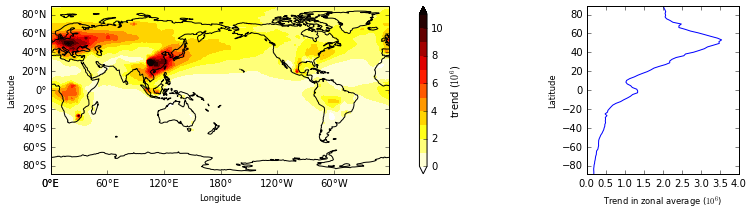

In [33]:
fig = plt.figure(figsize=[15, 3])
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 

lons = cube.coord('longitude').points
lats = cube.coord('latitude').points

plot_3D_trend(od_3D_trend, lons, lats, gs)
plot_2D_trend(od_2D_trend, lats, gs)

plt.show()

### Plot timeseries

In [34]:
regions = {'globe60': [-60, 60],
           'tropics': [-20, 20],
           'northern_extratropics60': [20, 60],
           'southern_extratropics60': [-60, -20],
          }

In [37]:
def region_mask(cube, south_bound, north_bound):
    """Create mask for excluding points not in region of interest.

    False corresponds to points that are not masked.

    Args:
      cube (iris.cube.Cube): Data cube
      south_bound (float): Southern boundary of region of interest
      north_bound (float): Northern boundary of region of interest 

    """

    data_mask = cube.data.mask
    dim_coord_names = [coord.name() for coord in cube.dim_coords]
    aux_coord_names = [coord.name() for coord in cube.aux_coords]
    
    lat_coord = cube.coord('latitude')
    
    vin_flag = numpy.vectorize(in_flag)
    in_region = vin_flag(lat_coord.points, south_bound, north_bound)

    if 'latitude' in dim_coord_names:
        lat_index = dim_coord_names.index('latitude')
        in_region = uconv.broadcast_array(in_region, lat_index, cube.shape)
    elif 'latitude' in aux_coord_names:
        dim_diff = len(dim_coord_names) - len(aux_coord_names)
        if dim_diff == 2:
            assert 'time' in dim_coord_names[0:2], "Last two axes must be spatial coordinates"
            assert 'depth' in dim_coord_names[0:2], "Last two axes must be spatial coordinates"
        elif dim_diff == 1:
            assert dim_coord_names[0] == 'depth', "Last two axes must be spatial coordinates"

        while in_region.ndim < data_mask.ndim:
            in_region = in_region[numpy.newaxis, ...]

    mask = data_mask + in_region

    return mask   


def in_flag(lat_value, south_bound, north_bound):
    """Determine if a point is in the region of interest.
   
    Returns false for points that are included (because they don't need
      to be masked)
    """

    if lat_value < north_bound and lat_value > south_bound:
        return False
    else:
        return True 
    

def regional_average(cube_copy, mask):
    """Calculate the heat content for each timestep."""

    cube_copy.data.mask = mask
    coord_names = [coord.name() for coord in cube_copy.coords()]
    coord_names.remove('time')
    ave = cube_copy.collapsed(coord_names, iris.analysis.MEAN)

    return ave

In [38]:
regional_averages = {}
for region, bounds in regions.iteritems():
    data_mask = region_mask(cube, bounds[0], bounds[-1])
    regional_averages[region] = regional_average(cube.copy(), data_mask)

NameError: global name 'uconv' is not defined